<h1>Importing the libraries</h1>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -U --no-cache-dir gdown --pre

download_ids = ['1q0bCtfz0DT5TrfTFeIv_8GQzH-TjkveM']

for id in download_ids:
  print("Attept download from", id)
  response = !gdown --id $id --output deepfake_data.tar.gz
  if response[0] == 'Downloading...':
    break
  else:
    continue

!unzip '/content/deepfake_data.tar.gz'

Streaming output truncated to the last 5000 lines.
  inflating: categorical/nv/ISIC_0026997.jpg  
  inflating: categorical/nv/ISIC_0026998.jpg  
  inflating: categorical/nv/ISIC_0026999.jpg  
  inflating: categorical/nv/ISIC_0027000.jpg  
  inflating: categorical/nv/ISIC_0027001.jpg  
  inflating: categorical/nv/ISIC_0027002.jpg  
  inflating: categorical/nv/ISIC_0027003.jpg  
  inflating: categorical/nv/ISIC_0027005.jpg  
  inflating: categorical/nv/ISIC_0027007.jpg  
  inflating: categorical/nv/ISIC_0027009.jpg  
  inflating: categorical/nv/ISIC_0027010.jpg  
  inflating: categorical/nv/ISIC_0027011.jpg  
  inflating: categorical/nv/ISIC_0027012.jpg  
  inflating: categorical/nv/ISIC_0027013.jpg  
  inflating: categorical/nv/ISIC_0027014.jpg  
  inflating: categorical/nv/ISIC_0027015.jpg  
  inflating: categorical/nv/ISIC_0027016.jpg  
  inflating: categorical/nv/ISIC_0027019.jpg  
  inflating: categorical/nv/ISIC_0027020.jpg  
  inflating: categorical/nv/ISIC_0027022.jpg  
  inflati

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import ModelCheckpoint
%matplotlib inline
import os

# Importing Dataset

Here we are loading the cifar10 Dataset which is preloaded in tensorflow. <br>

Calling the `load_data` function on this object returns splitted train and test data in form of (features, target).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_data_dir='/content/categorical'#/content/drive/00 thesis/data set/hum1000/thesis data asif/categorical resampled'
classes=os.listdir(train_data_dir)
img_height=256
img_width=256
batch_size=2 #previously was 128
train_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode= 'categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data
print(classes)
totalImages=0
for item in classes:
  folder=os.path.join(train_data_dir,item)
  datasize=os.listdir(folder)
  totalImages+=len(datasize)
  print(item,":",len(datasize))
print("total number of images are :",totalImages)

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
['vasc', 'akiec', 'df', 'bkl', 'mel', 'bcc', 'nv']
vasc : 142
akiec : 327
df : 115
bkl : 1099
mel : 1113
bcc : 514
nv : 6705
total number of images are : 10015


<h1>Plotting dataset</h1>

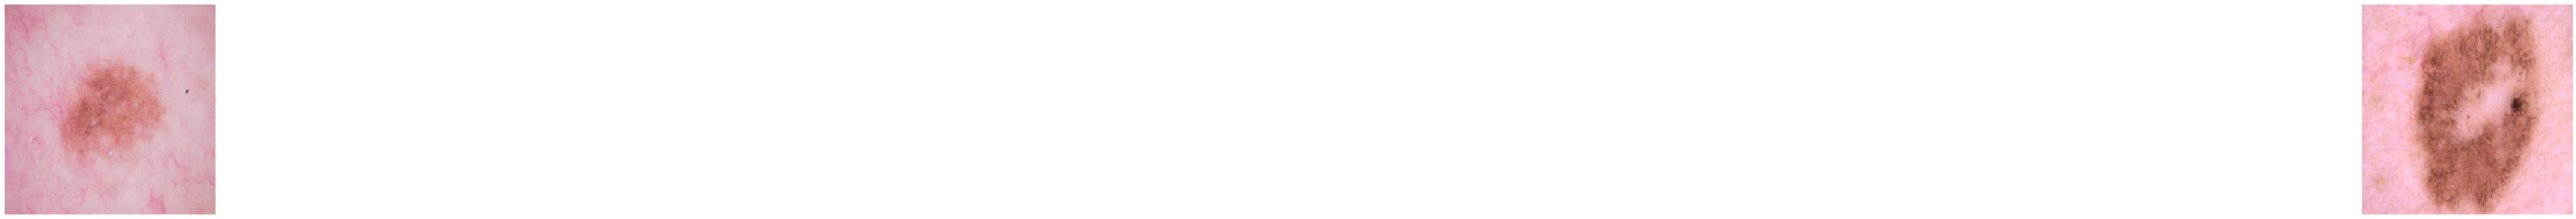

In [ ]:
def plots(ims, fig=(120,6) , rows=1, interp=False,titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims=np.array(ims).astype(np.uint8)
#     if (ims.shape[-1]!=3):
#         ims=ims.transpose((0,2,3,1))
    f=plt.figure(figsize=fig)
    cols=len(ims)//rows if len(ims)%2==0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp=f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i] , interpolation=None if interp else 'none')
        if i>10:
            break

x,y=next(train_generator)
plots(ims=x)

# Using the built-in Keras code and weights of VGG16


Keras provides access to a number of top-performing pre-trained models that were developed for image recognition tasks.

They are available via the Applications API, and include functions to load a model with or without the pre-trained weights, and prepare data in a way that a given model may expect (e.g. scaling of size and pixel values).

The first time a pre-trained model is loaded, Keras will download the required model weights, which may take some time given the speed of your internet connection. 

When loading a given model, the “include_top” argument can be set to False, in which case the model's fully-connected layers and the output layer, will not be loaded, allowing new layers to be added and trained. A model without a top will output activations from the last convolutional or pooling layer directly.
Additionally, when the “include_top” argument is False, the “input_tensor” argument must be specified, allowing the expected fixed-sized input of the model to be changed. 

Alternately, we may wish to use the VGG16 model layers, but train the new layers of the model without updating the weights of the VGG16 layers (aka freeze these weights). This will allow the new added layers to learn to interpret the learned features of the VGG16.
This can be achieved by setting the “trainable” property on each of the layers in the loaded VGG model to False prior to training. 
You can pick and choose which layers are trainable.


## Training

```model.fit``` trains the model.
> * **train_images**: Training data/features
* **train_labels**: Target
* **epochs**: Number of times the entire dataset is fed in the model



In [ ]:
from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
from glob import glob


IMAGE_SIZE=[img_height,img_width]
epochs=100


vgg=VGG16(input_shape=IMAGE_SIZE+[3],
         weights='imagenet',
         include_top=False)

#don't train existing weights
for layer in vgg.layers:
    layer.trainable=False

x=Flatten()(vgg.output)
prediction=Dense(len(classes), activation='softmax')(x)

#create a model object
model=Model(inputs=vgg.input,outputs=prediction)

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
filepath="/content/drive/MyDrive/00 thesis/data set/hum1000/thesis data asif/model/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights("/content/drive/MyDrive/00 thesis/data set/hum1000/thesis data asif/model/1-50/weights-improvement-42-0.57.hdf5")

In [ ]:
#fit the model
BS=2
history=model.fit_generator(train_generator,
                           validation_data=validation_generator,
                           epochs=epochs,
                           steps_per_epoch=8015//BS,
                           validation_steps=2000//BS,
                           callbacks = callbacks_list
                           )


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
4007/4007 [==============================] - 123s 30ms/step - loss: 2.4607 - accuracy: 0.5911 - val_loss: 1.6531 - val_accuracy: 0.6800

Epoch 00001: val_accuracy improved from -inf to 0.68000, saving model to /content/drive/MyDrive/00 thesis/data set/hum1000/thesis data asif/model/weights-improvement-01-0.68.hdf5
Epoch 2/100
4007/4007 [==============================] - 117s 29ms/step - loss: 2.3067 - accuracy: 0.6588 - val_loss: 2.7043 - val_accuracy: 0.6965

Epoch 00002: val_accuracy improved from 0.68000 to 0.69650, saving model to /content/drive/MyDrive/00 thesis/data set/hum1000/thesis data asif/model/weights-improvement-02-0.70.hdf5
Epoch 3/100
4007/4007 [==============================] - 117s 29ms/step - loss: 2.2420 - accuracy: 0.6725 - val_loss: 2.7262 - val_accuracy: 0.6505

Epoch 00003: val_accuracy did not improve from 0.69650
Epoch 4/100
4007/4007 [==============================] - 117s 29ms/step - loss: 2.1743 - accuracy: 0.6813 - val_loss: 3.6739 - val_accura